In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (4, 4)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['lines.linewidth'] = 3
sns.set()

## NBA

In [2]:
import requests
import os

def fetch():
    path = 'nba.csv'
    if not os.path.exists(path):
        url = 'https://stats.nba.com/stats/leaguegamelog/'
        params = (
            ('Counter', '0'),
            ('DateFrom', ''),
            ('DateTo', ''),
            ('Direction', 'ASC'),
            ('LeagueID', '00'),
            ('PlayerOrTeam', 'T'),
            ('Season', '2017-18'),
            ('SeasonType', 'Regular Season'),
            ('Sorter', 'DATE'),
        )
        headers = {
            'User-Agent': 'PostmanRuntime/7.4.0'
        }
        response = requests.get(url, params=params, headers=headers)
        data = response.json()['resultSets'][0]
        df = pd.DataFrame(data=data['rowSet'], columns=data['headers'])
        df.to_csv(path, index=False)
        return df
    else:
        return pd.read_csv(path)
    
df = fetch()

In [4]:
df.iloc[0]

SEASON_ID                            22017
TEAM_ID                         1610612744
TEAM_ABBREVIATION                      GSW
TEAM_NAME            Golden State Warriors
GAME_ID                           21700002
GAME_DATE                       2017-10-17
MATCHUP                        GSW vs. HOU
WL                                       L
MIN                                    240
FGM                                     43
FGA                                     80
FG_PCT                               0.538
FG3M                                    16
FG3A                                    30
FG3_PCT                              0.533
FTM                                     19
FTA                                     21
FT_PCT                               0.905
OREB                                     6
DREB                                    35
REB                                     41
AST                                     34
STL                                      5
BLK        

In [5]:
df['WON'] = df['WL'].astype('category').cat.codes

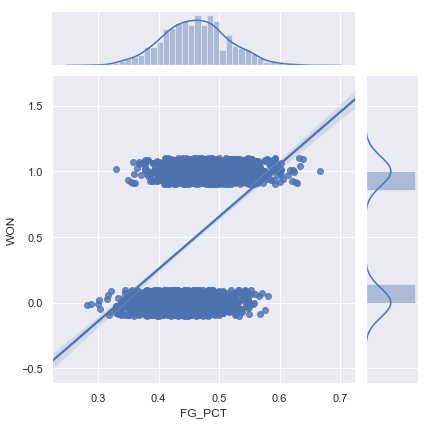

In [8]:
sns.jointplot('FG_PCT', 'WON', 
              kind='reg', y_jitter=0.1,
              data=df)

In [11]:
half = df[['TEAM_NAME', 'GAME_ID', 'FG_PCT', 'WON']]
pairs = half.groupby('GAME_ID')
games = pairs.first().join(pairs.last(), rsuffix='_OPP')
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                         0.409
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                     0.458
WON_OPP                            1
Name: 21700001, dtype: object

In [12]:
games = games.drop('WON_OPP', axis=1)
games['FG_PCT_DIFF'] = games['FG_PCT'] - games['FG_PCT_OPP']
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                         0.409
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                     0.458
FG_PCT_DIFF                   -0.049
Name: 21700001, dtype: object

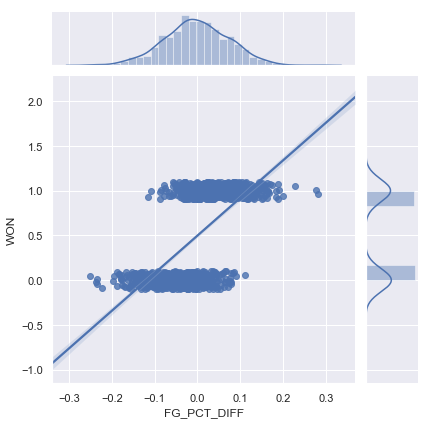

In [13]:
sns.jointplot('FG_PCT_DIFF', 'WON', 
              kind='reg', y_jitter=0.1,
              data=games);

In [14]:
bins = pd.cut(games['FG_PCT_DIFF'], 20)
mids = [(b.left + b.right)/2 for b in bins]
games['WON'].groupby(mids).size()

-0.2380      4
-0.2110      2
-0.1845     11
-0.1580     25
-0.1315     33
-0.1047     59
-0.0781    108
-0.0515    128
-0.0249    187
 0.0017    174
 0.0283    156
 0.0549    111
 0.0815    108
 0.1079     65
 0.1345     31
 0.1615     19
 0.1880      6
 0.2410      1
 0.2675      2
Name: WON, dtype: int64

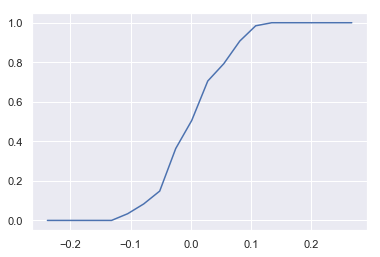

In [16]:
win_rates = games['WON'].groupby(mids).agg(lambda s: sum(s)/len(s))
win_rates.plot()

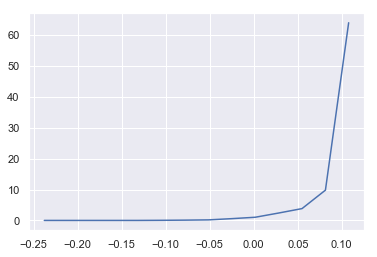

In [19]:
(win_rates / (1 - win_rates)).plot()

/Users/denero/anaconda3/envs/100/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


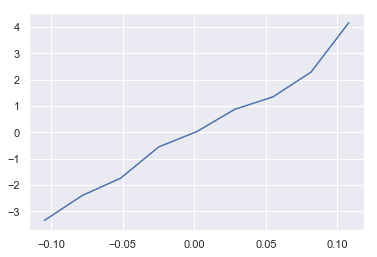

In [20]:
np.log(win_rates / (1 - win_rates)).plot()

## Logistic Regression

One way to model the relationship between vector-valued $X$ and the conditional distribution of a binary categorical $Y \in {0, 1}$ is to assume that the log odds ratio is linear in $X$:

$$\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) = X^T \beta$$

Abbreviate $P(Y=1|X)$ as $p$ and $X^T \beta$ as $t$, then:

\begin{align*}
\log \left( \frac{P(Y=1|X)}{P(Y=0|X)} \right) &= X^T \beta && \text{} \\[10pt]
\log \left( \frac{p}{1-p} \right) &= t && \text{; Abbreviate and complement rule} \\[10pt]
\frac{p}{1-p} &= \exp(t) && \text{; exponentiate both sides} \\[10pt]
p &= \exp(t) - p \exp(t) && \text{; multiply by $1-p$} \\[10pt]
p (1 + \exp(t)) &= \exp(t) && \text{; add $p \exp(t)$ and factor out $p$} \\[10pt]
p &= \frac{\exp(t)}{1 + \exp(t)} && \text{; divide by $1 + \exp(t)$} \\[10pt]
p &= \frac{1}{1 + \exp(-t)} && \text{; multiply by $\frac{\exp(-t)}{\exp(-t)}$} \\[10pt]
P(Y=1|X) &= \frac{1}{1 + \exp(-X^T \beta)} && \text{; Unabbreviate}
\end{align*}

This transformation is called the logistic function, traditionally denoted $\sigma$ (sigma).

$$\sigma(t) = \frac{1}{1 + \exp(-t)}$$

In [22]:
def sigma(t):
    return 1 / (1 + np.exp(-t))

In [23]:
sigma(90)

1.0

In [24]:
sigma(-90)

8.194012623990515e-40

In [25]:
sigma(0)

0.5

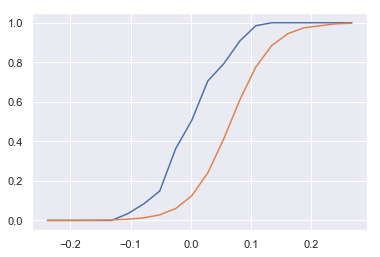

In [39]:
fg_pct_diffs = np.array(win_rates.index)
fg_pct_diffs
win_rates.plot()
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * 30 + bias * -2))

In [32]:
fg_pct_diffs

array([-0.238 , -0.211 , -0.1845, -0.158 , -0.1315, -0.1047, -0.0781,
       -0.0515, -0.0249,  0.0017,  0.0283,  0.0549,  0.0815,  0.1079,
        0.1345,  0.1615,  0.188 ,  0.241 ,  0.2675])

In [35]:
bias = np.ones(len(fg_pct_diffs))
bias

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.])

In [ ]:
def flatten(li): 
    return [item for sub in li for item in sub]

bs = [-2, -1, -0.5, 2, 1, 0.5]
xs = np.linspace(-10, 10, 100)

fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10, 6))
for ax, b in zip(flatten(axes), bs):
    ys = sigma(xs * b)
    ax.plot(xs, ys)
    ax.set_title(r'$ b = $' + str(b))

# add a big axes, hide frame
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top=False, bottom=False,
                left=False, right=False)
plt.grid(False)
plt.xlabel('$x$')
plt.ylabel(r'$ \frac{1}{1+\exp(-b \cdot x)} $')
plt.tight_layout()

## Log Loss (a.k.a., Cross-Entropy Loss)

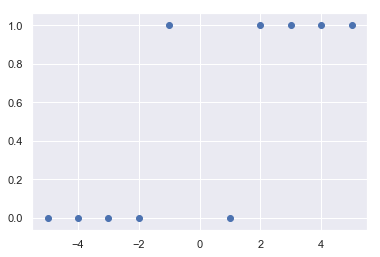

In [40]:
toy = pd.DataFrame({
    'X': [-5, -4, -3, -2, -1, 1, 2, 3, 4, 5],
    'Y': [ 0,  0,  0,  0,  1, 0, 1, 1, 1, 1]
})
plt.scatter(toy['X'], toy['Y']);

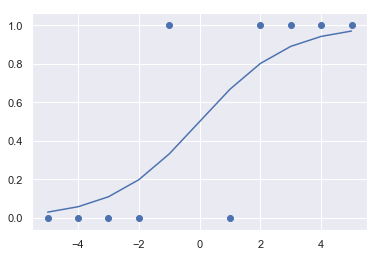

In [50]:
plt.scatter(toy['X'], toy['Y']);
plt.plot(toy['X'], sigma(toy['X'] * 0.7))

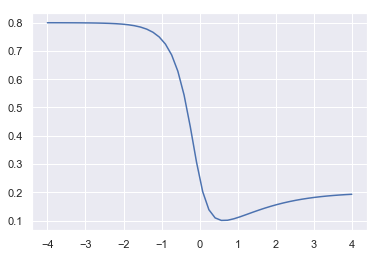

In [49]:
def squared_loss(y, y_hat):
    return (y - y_hat) ** 2

def empirical_risk(b, loss):
    y_hats = sigma(toy['X'] * b)
    losses = [loss(y, y_hat) for y, y_hat in zip(toy['Y'], y_hats)]
    return np.average(losses)

bs = np.linspace(-4, 4, 50)

plt.plot(bs, [empirical_risk(b, squared_loss) for b in bs])

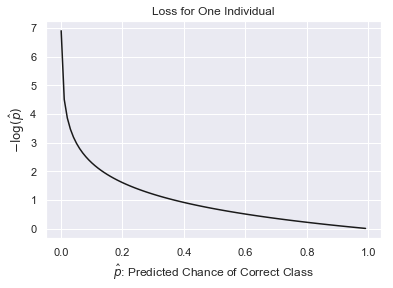

In [51]:
p_hat = np.arange(0.001, 0.999, 0.01)
loss = -np.log(p_hat)
plt.plot(p_hat, loss, color='k')
plt.xlabel('$\hat{p}$: Predicted Chance of Correct Class')
plt.ylabel('$-\log(\hat{p})$')
plt.title('Loss for One Individual');

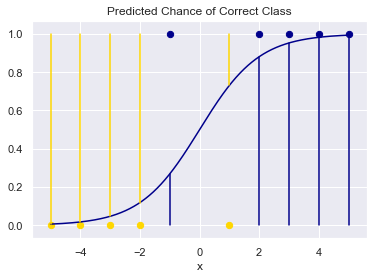

In [52]:
# Predicted chance of class 1.
x = np.arange(-5, 5, 0.01)
px = sigma(x)
plt.plot(x, px, color = 'darkblue')

def add_points(xs, y, color):
    plt.scatter(xs, [y] * len(xs), color=color, s=40)
    for x in xs:
        plt.plot([x, x], [1-y, sigma(x)], color=color)

add_points(np.array([-5, -4, -3, -2, 1]), 0, 'gold')
add_points(np.array([-1, 2, 3, 4, 5]), 1, 'darkblue')
        
plt.xlabel('x')
plt.title('Predicted Chance of Correct Class');

Log loss (a.k.a., cross-entropy loss)
$$
-y_i\log(\sigma(x_i^T \beta)) - (1-y_i)\log(1-\sigma(x_i^T \beta))
$$

Text(0, 0.5, 'empirical risk')

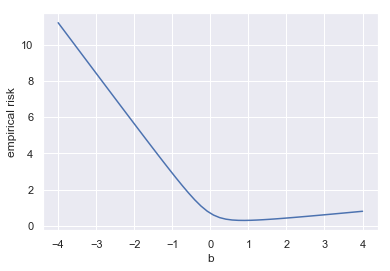

In [53]:
def log_loss(y, y_hat):
    return -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)

plt.plot(bs, [empirical_risk(b, log_loss) for b in bs]);
plt.xlabel('b')
plt.ylabel('empirical risk')

## Applying Logistic Regression

In [54]:
games.iloc[0]

TEAM_NAME             Boston Celtics
FG_PCT                         0.409
WON                                0
TEAM_NAME_OPP    Cleveland Cavaliers
FG_PCT_OPP                     0.458
FG_PCT_DIFF                   -0.049
Name: 21700001, dtype: object

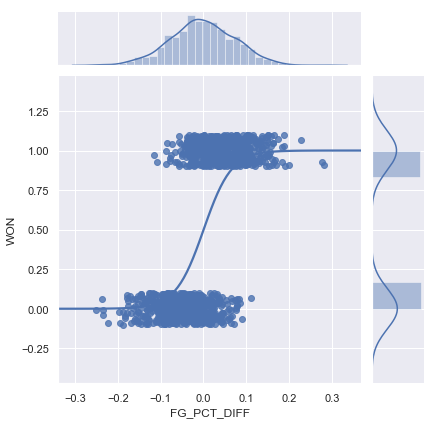

In [56]:
sns.jointplot('FG_PCT_DIFF', 'WON', 
              kind='reg', y_jitter=0.1, 
              logistic=True, ci=None,
              data=games);

In [58]:
from scipy.optimize import minimize

def risk(beta):
    y_hat = predict(beta)
    y = games['WON']
    losses = -y * np.log(y_hat) - (1-y) * np.log(1-y_hat)
    return np.average(losses)

def predict(beta):
    return sigma(games['FG_PCT_DIFF'] * beta)

minimize(risk, 1)

      fun: 0.42957549456281086
 hess_inv: array([[3723.16404667]])
      jac: array([-1.82539225e-07])
  message: 'Optimization terminated successfully.'
     nfev: 36
      nit: 8
     njev: 12
   status: 0
  success: True
        x: array([30.57883679])

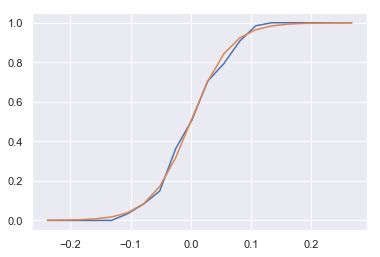

In [61]:

fg_pct_diffs = np.array(win_rates.index)
fg_pct_diffs
win_rates.plot()
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * 30.5788))

In [ ]:
b = minimize(risk, 1)['x'][0]
win_rates.plot();
plt.plot(fg_pct_diffs, sigma(fg_pct_diffs * b));